In [4]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import matplotlib.pyplot as plt

In [2]:
## define the dictionary of digit segments 
## so we can identify each digit in the image

DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 1, 0): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

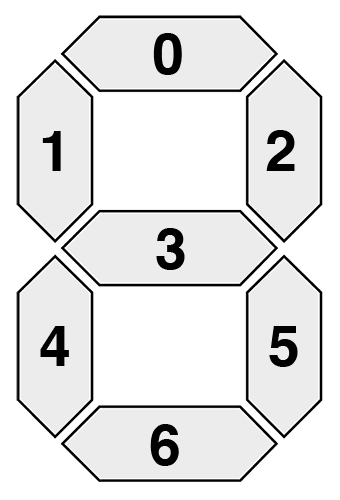

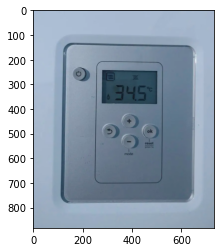

In [5]:
## Edge detection
image = cv2.imread(r'D:\Users\DELL\Desktop\Computer Vision\OpenCV Tutorial\example.webp')
plt.imshow(image)
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edged = cv2.Canny(blurred, 100, 200, 255)

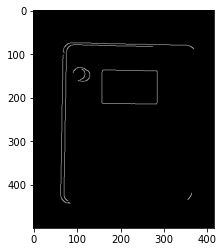

In [7]:
cv2.imshow("edged", edged)
cv2.waitKey(0)

plt.imshow(edged, cmap='gray')

In [8]:
## Finding contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None

# Loop over contours"
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*peri, True)
    
    if len(approx) == 4:
        displayCnt = approx
        break

In [9]:
# Perspective Transform of screen
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

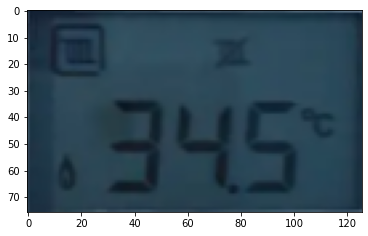

In [10]:
cv2.imshow("output", output)
cv2.waitKey(0)

plt.imshow(output)

In [11]:
## Thresholding & Cleaning the image
thresh = cv2.threshold(warped, 0, 255,
                      cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

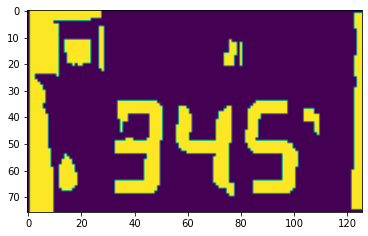

In [12]:
cv2.imshow("thresh", thresh)
cv2.waitKey(0)

plt.imshow(thresh)

In [13]:
## Finding contours of digits in the thresh image
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL,
                       cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []

img = thresh.copy()
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    
    if w >= 15 and (h >= 30 and h <= 40):
        digitCnts.append(c)
    
    print(x, y, w, h)

12 54 7 14
104 37 6 10
56 36 22 34
82 34 20 35
33 34 18 35
80 12 1 9
74 11 5 10
14 11 10 10
27 6 2 17
122 1 4 74
1 0 27 76


In [14]:
len(digitCnts)

3

In [15]:
digitCnts = contours.sort_contours(digitCnts,
                                  method = "left-to-right")[0]
digits = []

In [16]:
for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    roi = thresh[y:y+h, x:x+w]
    
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW*0.25), int(roiH*0.15))
    dHC = int(roiH * 0.05)
    
    segments = [
        ((0, 0), (w, dH)),	# top
        ((0, 0), (dW, h // 2)),	# top-left
        ((w - dW, 0), (w, h // 2)),	# top-right
        ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
        ((0, h // 2), (dW, h)),	# bottom-left
        ((w - dW, h // 2), (w, h)),	# bottom-right
        ((0, h - dH), (w, h))	# bottom
    ]
    
    on = [0]*len(segments)
    
    # Loop pver the segments
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        segROI = roi[yA:yB, xA:xB]
        total = cv2.countNonZero(segROI)
        area = (xB-xA) * (yB-yA)
        
        if total / float(area) > 0.5:
            on[i] = 1
            
    # lookup the digit and draw it on the image
    digit = DIGITS_LOOKUP[tuple(on)]
    digits.append(digit)
    cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 1)
    cv2.putText(output, str(digit), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

In [20]:
# display the digits
print(u"{}{}.{} \u00b0C".format(*digits))
cv2.imshow("Input", image)
cv2.imshow("Output", output)
cv2.waitKey(0)

34.5 °C
-1
